In [24]:

%matplotlib inline


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.stats import norm

# -----------------------------
# 1. Define True Growth Function
# -----------------------------
def true_growth_function(x1, x2, x3, noise=0.05):
    """Fake organism growth depending on 3 chemical concentrations."""
    noise_term = np.random.normal(0, noise)
    return (
        np.sin(3*np.pi*x1) * np.cos(2*np.pi*x2)
        + 0.5*x1**2
        - 0.3*(x2-0.5)**2
        + np.sin(5*np.pi*x3)
        + noise_term
    )

# -----------------------------
# 2. Generate Fake Data
# -----------------------------
np.random.seed(42)
n_samples = 50
X_init = np.random.rand(n_samples, 3)
y_init = np.array([true_growth_function(x[0], x[1], x[2]) for x in X_init])



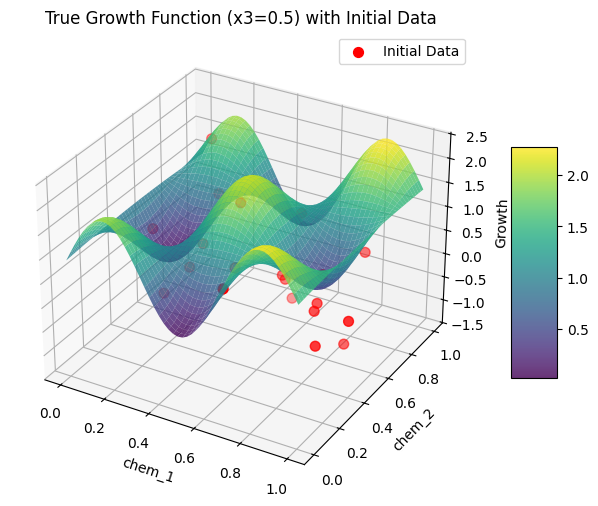

In [30]:
# -----------------------------
# 3. Plot true growth function and initial data
# -----------------------------
# Fix x3 to 0.5 for visualization
fixed_x3 = 0.5
resolution = 50
x1 = np.linspace(0, 1, resolution)
x2 = np.linspace(0, 1, resolution)
X1, X2 = np.meshgrid(x1, x2)

# Compute true growth values on the grid
Z_true = np.array([[true_growth_function(a, b, fixed_x3, noise=0) 
                    for a, b in zip(row_x1, row_x2)]
                   for row_x1, row_x2 in zip(X1, X2)])

# Plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X1, X2, Z_true, cmap=cm.viridis, alpha=0.8)

# Plot initial data (only those with x3 ~ fixed_x3 ± 0.05 to visualize on this slice)
slice_mask = np.abs(X_init[:,2] - fixed_x3) < 0.2
ax.scatter(X_init[slice_mask,0], X_init[slice_mask,1], y_init[slice_mask], 
           c='red', s=50, label='Initial Data')

ax.set_xlabel('chem_1')
ax.set_ylabel('chem_2')
ax.set_zlabel('Growth')
ax.set_title(f'True Growth Function (x3={fixed_x3}) with Initial Data')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.legend()
plt.show()


In [18]:
# -----------------------------
# 3. Define Search Space
# -----------------------------
space = [Real(0.0, 1.0, name=f"chem_{i+1}") for i in range(3)]

# -----------------------------
# 4. Train Gaussian Process Surrogate
# -----------------------------
kernel = ConstantKernel(1.0) * Matern(length_scale=0.2, nu=2.5) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
gp.fit(X_init, y_init)

# -----------------------------
# 5. Define Objective for BO
# -----------------------------
@use_named_args(space)
def objective(**params):
    x = np.array([params["chem_1"], params["chem_2"], params["chem_3"]]).reshape(1, -1)
    pred, _ = gp.predict(x, return_std=True)
    return -float(pred)  # minimize negative predicted growth

# -----------------------------
# 6. Visualization Utilities
# -----------------------------
def plot_surface_3d(func, fixed_dim_index=2, fixed_value=0.5, resolution=50, title=""):
    """
    Plot a 2D surface while fixing the third input dimension.
    """
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X1, X2 = np.meshgrid(x, y)
    Z = np.zeros_like(X1)
    
    for i in range(resolution):
        for j in range(resolution):
            point = [0, 0, 0]
            indices = [0, 1, 2]
            indices.remove(fixed_dim_index)
            point[indices[0]] = X1[i,j]
            point[indices[1]] = X2[i,j]
            point[fixed_dim_index] = fixed_value
            Z[i,j] = func(np.array([point]))
    
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8)
    ax.set_xlabel(f"chem_{indices[0]+1}")
    ax.set_ylabel(f"chem_{indices[1]+1}")
    ax.set_zlabel("Growth")
    ax.set_title(title + f" (chem_{fixed_dim_index+1}={fixed_value})")
    fig.colorbar(surf)
    plt.show()

def surrogate_prediction(x):
    pred, _ = gp.predict(x, return_std=True)
    return float(pred)

# -----------------------------
# 7. Visualize True Function & Surrogate
# -----------------------------
plot_surface_3d(lambda x: true_growth_function(*x[0]), fixed_dim_index=2, fixed_value=0.5, title="True Growth")
plot_surface_3d(surrogate_prediction, fixed_dim_index=2, fixed_value=0.5, title="GP Surrogate")

# -----------------------------
# 8. Run Bayesian Optimization
# -----------------------------
result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=25,
    n_initial_points=5,
    acq_func="EI",
    random_state=42
)

# -----------------------------
# 9. Show Results
# -----------------------------
X_opt = np.array(result.x)
print(f"\nBest found concentrations: chem_1={X_opt[0]:.3f}, chem_2={X_opt[1]:.3f}, chem_3={X_opt[2]:.3f}")
print(f"Predicted maximum growth: {-result.fun:.3f}")

# Visualize the optimum in the 2D slice for chem_3 fixed at optimum
plot_surface_3d(surrogate_prediction, fixed_dim_index=2, fixed_value=X_opt[2], title="GP Surrogate with optimum slice")


/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


<IPython.core.display.Javascript object>

/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7290/3981045028.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred)
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7290/3981045028.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred)
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7290/3981045028.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred)
/var/folders/9g/q_w246652jsf

<IPython.core.display.Javascript object>

/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7290/3981045028.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(pred)  # minimize negative predicted growth
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7290/3981045028.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(pred)  # minimize negative predicted growth
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7290/3981045028.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operati


Best found concentrations: chem_1=0.523, chem_2=0.545, chem_3=0.058
Predicted maximum growth: 1.541


<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

# -----------------------------
# 1. Fake 3D growth function
# -----------------------------
def true_growth_function(x1, x2, x3, noise=0.0):
    """True organism growth function (no noise for visualization)."""
    return np.sin(3*np.pi*x1) * np.cos(2*np.pi*x2) + 0.5*x1**2 - 0.3*(x2-0.5)**2 + np.sin(5*np.pi*x3)

# -----------------------------
# 2. Generate fake training data
# -----------------------------
np.random.seed(42)
n_samples = 50
X_train = np.random.rand(n_samples, 3)
y_train = np.array([true_growth_function(x[0], x[1], x[2]) for x in X_train])

# -----------------------------
# 3. Fit Gaussian Process surrogate
# -----------------------------
kernel = ConstantKernel(1.0) * Matern(length_scale=0.2, nu=2.5) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
gp.fit(X_train, y_train)

# -----------------------------
# 4. Visualization function for 2D slice
# -----------------------------
def plot_true_vs_surrogate(f_true, gp_model, fixed_dim_index=2, fixed_value=0.5, resolution=50):
    """
    Plot true function vs GP surrogate for a 2D slice with the fixed dimension.
    """
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X1, X2 = np.meshgrid(x, y)
    Z_true = np.zeros_like(X1)
    Z_surrogate = np.zeros_like(X1)

    for i in range(resolution):
        for j in range(resolution):
            point = [0, 0, 0]
            indices = [0, 1, 2]
            indices.remove(fixed_dim_index)
            point[indices[0]] = X1[i,j]
            point[indices[1]] = X2[i,j]
            point[fixed_dim_index] = fixed_value
            Z_true[i,j] = f_true(*point)
            Z_surrogate[i,j] = gp_model.predict(np.array([point]))[0]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12,5), subplot_kw={'projection':'3d'})
    
    surf1 = axes[0].plot_surface(X1, X2, Z_true, cmap=cm.viridis, alpha=0.8)
    axes[0].set_title("True Growth Function")
    axes[0].set_xlabel(f"chem_{indices[0]+1}")
    axes[0].set_ylabel(f"chem_{indices[1]+1}")
    axes[0].set_zlabel("Growth")
    fig.colorbar(surf1, ax=axes[0])

    surf2 = axes[1].plot_surface(X1, X2, Z_surrogate, cmap=cm.viridis, alpha=0.8)
    axes[1].set_title("GP Surrogate Prediction")
    axes[1].set_xlabel(f"chem_{indices[0]+1}")
    axes[1].set_ylabel(f"chem_{indices[1]+1}")
    axes[1].set_zlabel("Growth")
    fig.colorbar(surf2, ax=axes[1])

    plt.tight_layout()
    plt.show()

# -----------------------------
# 5. Plot true vs surrogate
# -----------------------------
plot_true_vs_surrogate(true_growth_function, gp, fixed_dim_index=2, fixed_value=0.5)


In [ ]:
from skopt.utils import use_named_args
from skopt.space import Real

# Define your search space
space = [Real(0.0, 1.0, name=f"chem_{i+1}") for i in range(3)]  # 3 chemicals

@use_named_args(space)
def objective(**params):
    # Convert dictionary to array
    x = np.array([params["chem_1"], params["chem_2"], params["chem_3"]]).reshape(1, -1)
    pred, _ = gp.predict(x, return_std=True)  # GP surrogate prediction
    return -float(pred)  # minimize negative growth to maximize growth


In [ ]:
from skopt import gp_minimize

result = gp_minimize(
    func=objective,        # our function to minimize (-growth)
    dimensions=space,      # search space
    n_calls=10,            # total number of iterations
    n_initial_points=3,    # initial random points
    acq_func="EI",         # acquisition function: Expected Improvement
    random_state=42
)


In [ ]:
next_concentrations = result.x
print("Next suggested concentrations to test:")
for i, val in enumerate(next_concentrations):
    print(f"chem_{i+1} = {val:.4f}")

# Predicted maximum growth
print(f"Predicted growth: {-result.fun:.4f}")


In [ ]:
from copy import deepcopy

# Copy of your current GP and data
X_current = X_train.copy()
y_current = y_train.copy()
gp_current = deepcopy(gp)

next_points = []
n_suggestions = 5

for _ in range(n_suggestions):
    # Define objective based on current GP
    def objective_single(x):
        pred, _ = gp_current.predict(np.array(x).reshape(1,-1), return_std=True)
        return -float(pred)
    
    # Use a small number of calls to find the maximum quickly
    from skopt import gp_minimize
    result = gp_minimize(
        func=objective_single,
        dimensions=space,
        n_calls=20,
        n_initial_points=5,
        acq_func="EI",
        random_state=42
    )
    
    # Record the suggested point
    next_point = result.x
    next_points.append(next_point)
    
    # Add the predicted point with predicted value to GP
    pred, _ = gp_current.predict(np.array(next_point).reshape(1,-1), return_std=True)
    X_current = np.vstack([X_current, next_point])
    y_current = np.append(y_current, float(pred))
    gp_current.fit(X_current, y_current)

# Print suggested next 5 reactions
for i, p in enumerate(next_points):
    print(f"Suggested reaction {i+1}: {[f'{v:.4f}' for v in p]}")
